# Bestmögliches Regressionsmodell - kaggle-Contest

Challenge: cml1/3Db Immobilienrechner <br/>
Team: Alexander Shanmugam, Si Ben Tran, Gabriel Torrez Gamez, Haris Alic <br/>
Aufgabe: 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vegleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.



---
# Module importieren

Hier in diesem Abschnitt importieren wir die wichtigisten Module, die wir für die weitere Bearbeitung unserer Machine Learning Modelle benötigen, um die Vorhersage des Immobilienpreises zu erstellen.

In [23]:
# Basic Data Science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules

## pipeline
from sklearn.pipeline import make_pipeline

## preprocessing
from sklearn.preprocessing import StandardScaler

## linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

## neighbors
from sklearn.neighbors import KNeighborsRegressor

## tree
from sklearn.tree import DecisionTreeRegressor

## ensemble
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

## model_selection
from sklearn.model_selection import train_test_split, GridSearchCV

## metrics
from sklearn.metrics import mean_absolute_percentage_error

# xgboost
import xgboost as XGBRegressor



---
# Daten importieren

Hier in diesem Abschnitt importieren wir die Immobilien Daten, die uns Fernando zur Verfügung gestellt hat.

v1 ist der von uns bearbeitete und bereinigter Datensatz 

v2 ist der von Fernando bearbeitete und bereinigter Datensatz 

In [2]:
# url and relative path for the data

rel_path_v1 = "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean_gde.csv"
# Clean data einlesen
rel_path_v2 = "../data/immo_data_202208_v2.csv"

# Read data into pandas dataframe
raw_df_v1 = pd.read_csv(rel_path_v1, index_col=0)
raw_df_v2 = pd.read_csv(rel_path_v2)

C:\Users\Si Ben Tran\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (6,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Si Ben Tran\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
# Daten vorbereiten

Hier werden die Daten vorbereitet, indem wir die Daten in Trainings- und Validierungsdaten aufteilen.
Die Testdaten befinden sich bereits auf der Kaggle Plattform und werden von Fernando zur Verfügung gestellt.

In [3]:
# drop the columns municipality, street, street_nr and zip_code
df_v1 = raw_df_v1.drop(columns=["municipality", "street", "street_nr", "zip_code", "availability"])

# count number of dtypes
print("Number of dtypes:", df_v1.dtypes.value_counts())

# print dtypes object columns
print("Dtypes object columns:", df_v1.select_dtypes(include="object").columns)

# make one hot encoding for the columns objects
df_v1 = pd.get_dummies(df_v1, columns = ['canton', 'type'])

# print shape of df_v1
print("Shape of df_v1:", df_v1.shape) 

# get top 10 cols with highest NA values
print("Top 10 cols with highest NA values:", df_v1.isna().sum().sort_values(ascending=False).head(30))


Number of dtypes: float64    54
object      2
int64       1
dtype: int64
Dtypes object columns: Index(['canton', 'type'], dtype='object')
Shape of df_v1: (21424, 124)
Top 10 cols with highest NA values: floor_space                18551
plot_area                  16586
floor                      15938
gde_politics_pda           10206
rooms                       8910
gde_politics_bdp            8207
gde_politics_rights         6156
gde_politics_glp            5340
gde_politics_evp            4153
living_space                1504
price                       1031
gde_politics_gps             495
gde_politics_cvp             334
gde_politics_fdp             157
gde_politics_sp              102
gde_politics_svp              55
canton_UR                      0
type_Farm house                0
canton_SO                      0
canton_SZ                      0
canton_TG                      0
type_Hobby room                0
type_Granny flat               0
type_Furnished dwelling        0
type_

## Daten V1 

Hier bearbeiten wir die Daten, die wir anfang 3. Semester erhalten haben.

In [4]:
# splitting dataframe into train and test set
train_v1, test_v1 = train_test_split(df_v1, test_size=0.2, random_state=42)

# splitting train_v1 and test_v1 into X and y 
X_train_v1 = train_v1.drop("price", axis=1)
y_train_v1 = train_v1["price"]

X_test_v1 = test_v1.drop("price", axis=1)
y_test_v1 = test_v1["price"]

# print shape of X_train_v1, y_train_v1, X_test_v1, y_test_v1
print("Shape of X_train_v1: ", X_train_v1.shape)
print("Shape of y_train_v1: ", y_train_v1.shape)
print("Shape of X_test_v1: ", X_test_v1.shape)
print("Shape of y_test_v1: ", y_test_v1.shape)

Shape of X_train_v1:  (17139, 123)
Shape of y_train_v1:  (17139,)
Shape of X_test_v1:  (4285, 123)
Shape of y_test_v1:  (4285,)


## Daten V2

Hier bearbeiten wir die Daten, die wir von Fernando in der Mitte des Semester (18.11.2022) erhalten haben. <br/>
Die Dokumentation der Features ist unter folgenden Link zu finden: [Link](www.gooogle.com)

In [5]:
# CODE

---
# Development Data 

Um unsere Modelle zu entwickeln, verwenden wir die Development Data fuer das erste. 
Im Zeiten druchlauf verwenden wir dann unseren Immobilien Datensatz. 

In [99]:
# load sklearn diabetes dataset
from sklearn.datasets import load_diabetes

# load dataset
diabetes = load_diabetes()

# create dataframe
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# add target to dataframe
df["target"] = diabetes.target

# split dataframe into train and test set
train, test = train_test_split(df, test_size=0.2, random_state=42)

# split train and test set into X and y
X_train_dev = train.drop("target", axis=1)
y_train_dev = train["target"]

X_test_dev = test.drop("target", axis=1)
y_test_dev = test["target"]

# print shape of X_train, y_train, X_test, y_test
print("Shape of X_train: ", X_train_dev.shape)
print("Shape of y_train: ", y_train_dev.shape)
print("Shape of X_test: ", X_test_dev.shape)
print("Shape of y_test: ", y_test_dev.shape)


Shape of X_train:  (353, 10)
Shape of y_train:  (353,)
Shape of X_test:  (89, 10)
Shape of y_test:  (89,)


---
# Modell 1 - Multiple Lineare Model 

Modell 1 ist ein multiples lineares Modell, welches wir als Benchmark für die weiteren Modelle verwenden werden. Wir haben uns für dieses Modell entschieden, da es ein einfaches Modell ist, welches wir schnell erstellen können und es uns ermöglicht, die Vorhersage des Preises zu erstellen.

[fernando] -> Gewichtung der Features

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'fit_intercept': True, 'positive': False}
Mean absolute percentage error: 0.37499812530899335


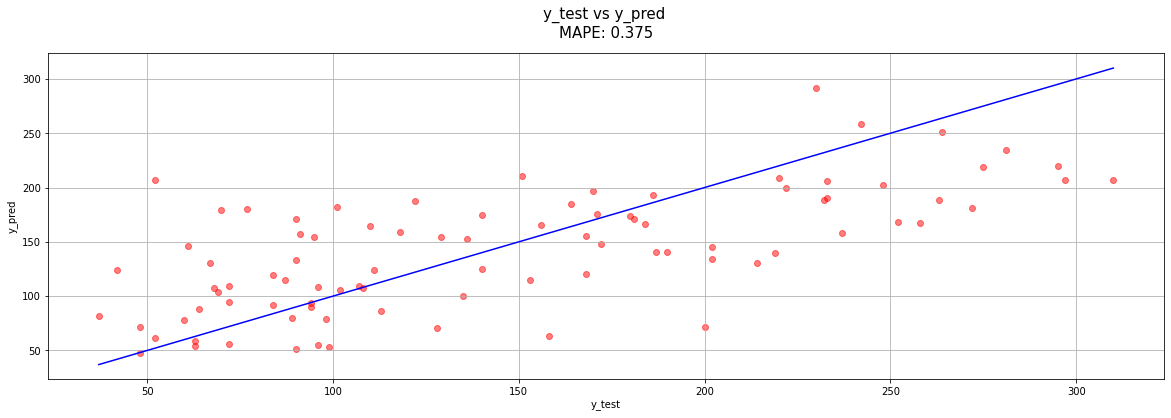

In [93]:
# make a linear regression function with gridsearchcv
def linear_regression(X_train, y_train, X_test, y_test, cv=5, verbose=1):
    """
    Function to make a linear regression model with gridsearchcv.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Target values.
    X_test : array-like
        Test data.
    y_test : array-like
        Target values.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.
     
    Returns
    -------
    model : object
        the best linear regression fitted model 
    """
    

    # create a linear regression model
    lin_reg = LinearRegression()

     # create a dictionary with the parameters
    params = {"fit_intercept": [True, False],
              "positive": [True, False],}

    # create a gridsearchcv model
    lin_reg_grid = GridSearchCV(lin_reg, params, cv=cv, n_jobs=-1, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    lin_reg_grid.fit(X_train, y_train)
    
    # print the best parameters
    print("Best params:", lin_reg_grid.best_params_)

    # make predictions
    y_pred_lin = lin_reg_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_lin_reg = mean_absolute_percentage_error(y_test, y_pred_lin)
    print("Mean absolute percentage error:", mape_lin_reg)

    # create y_test and y_pred plot
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred_lin, c="red", alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, c="blue")
    plt.grid()
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.title("y_test vs y_pred \nMAPE: " + str(np.round(mape_lin_reg, 4)) , fontsize = 15, y = 1.03)
    plt.show()

    return lin_reg_grid

# call function linear_regression for dev data
linear_regression_dev = linear_regression(X_train_dev, y_train_dev, X_test_dev, y_test_dev, cv=5, verbose=1)

---
# Modell 2 - Lasso Regression

Modell 2 ist ein multiples lineares Lasso Modell. 

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters: {'alpha': 0.021544346900318832, 'fit_intercept': True, 'max_iter': 1000.0, 'positive': False, 'random_state': 42, 'selection': 'cyclic'}
Mean absolute percentage error: 0.37387791278228594


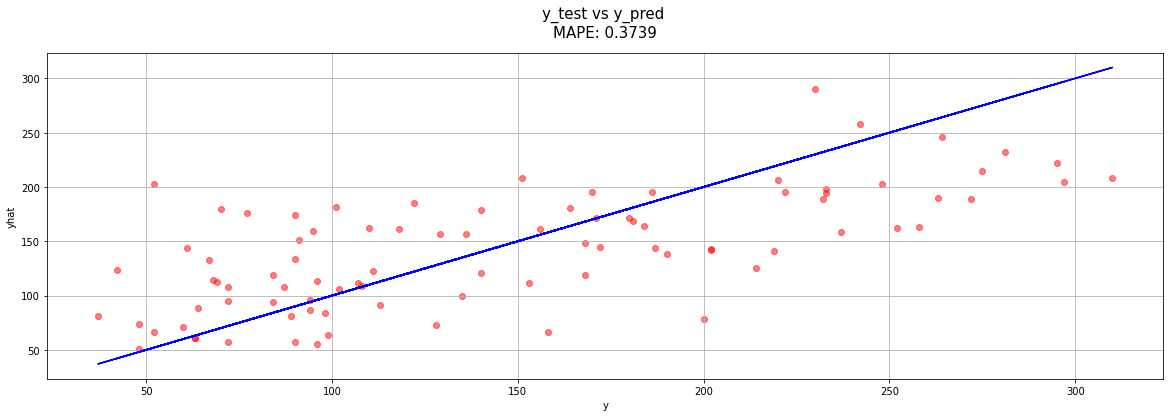

In [94]:
# make a lasso regression function with gridsearchCV
def lasso_regression_gridsearchCV(X_train, y_train, X_test, y_test, alphas = [1], iterations = [1000], cv=5, verbose=1):
    '''
    This function makes a lasso regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    alphas : numpy array
        alphas for the lasso regression.
    iterations : numpy array
        iterations for the lasso regression.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best lasso regression fitted model
    '''
    # create Lasso Modell with gridsearch cv
    lasso = Lasso()

    # create parameter grid
    param_grid = {"alpha": alphas,
                  "fit_intercept": [True, False],
                  "max_iter": iterations,
                  "random_state": [42],
                  "positive": [True, False],
                  "selection": ["random", "cyclic"]}

    # create gridsearchcv model
    lasso_grid = GridSearchCV(lasso, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    lasso_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", lasso_grid.best_params_)

    # predict the model
    y_pred_lasso = lasso_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)
    print("Mean absolute percentage error:", mape_lasso)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred_lasso, c="red", alpha=0.5)
    plt.plot(y_test, y_test, c="blue")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred \nMAPE: " + str(np.round(mape_lasso, 4)) , fontsize = 15, y = 1.03)
    plt.show()

    return lasso_grid
    
# call the function
lasso_regression_dev = lasso_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.logspace(-2, 1, 10), np.logspace(3,4,10), cv = 5, verbose = 1)

---
# Modell 3 - Ridge Regression

Modell 3 ist ein multiples lineares Ridge Modell.

Fitting 2 folds for each of 400 candidates, totalling 800 fits
Best parameters: {'alpha': 0.021544346900318832, 'fit_intercept': True, 'max_iter': 1000.0, 'positive': False, 'random_state': 42}
Mean absolute percentage error: 0.37372618507772903


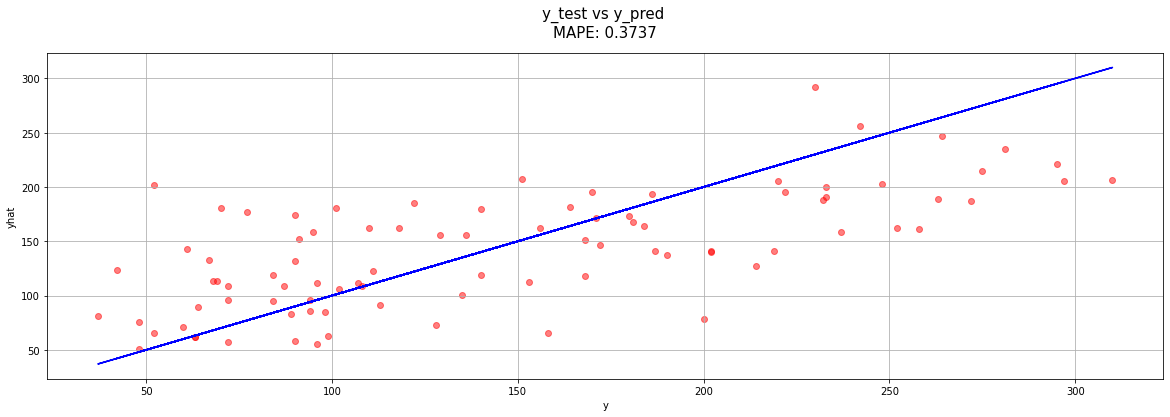

In [102]:
# make a ridge regression function with gridsearchCV
def ridge_regression_gridsearchCV(X_train, y_train, X_test, y_test, alphas = [1], iterations = [1000], cv = 5, verbose = 1):
    '''
    This function makes a ridge regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    alphas : numpy array
        alphas for the ridge regression.
    iterations : numpy array
        iterations for the ridge regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.


    Returns
    -------
    model : object
        the best ridge regression fitted model 
    '''
    # create Ridge Modell with gridsearch cv
    ridge = Ridge()

    # create parameter grid
    param_grid = {"alpha": alphas,
                  "fit_intercept": [True, False],
                  "max_iter": iterations,
                  "positive": [True, False],
                  "random_state": [42]}

    # create gridsearchcv model
    ridge_grid = GridSearchCV(ridge, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    ridge_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", ridge_grid.best_params_)

    # overwrite the model with the best model
    ridge_grid = ridge_grid.best_estimator_

    # predict the model
    y_pred_ridge = ridge_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)
    print("Mean absolute percentage error:", mape_ridge)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred_ridge, c="red", alpha=0.5)
    plt.plot(y_test, y_test, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred \nMAPE: " + str(np.round(mape_ridge, 4)) , fontsize = 15, y = 1.03)
    plt.show()

    return ridge_grid

# call the function
ridge_regression_dev = ridge_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.logspace(-2, 1, 10), iterations = np.logspace(3,4,10), cv = 2, verbose = 1)

---
# Modell 4 - Elastic Net Regression

Modell 4 ist ein multiples lineares Elastic Net Modell.

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'alpha': 1.0, 'l1_ratio': 0.01}
best estimator: ElasticNet(l1_ratio=0.01)
Mean absolute percentage error: 1.3029844265738453


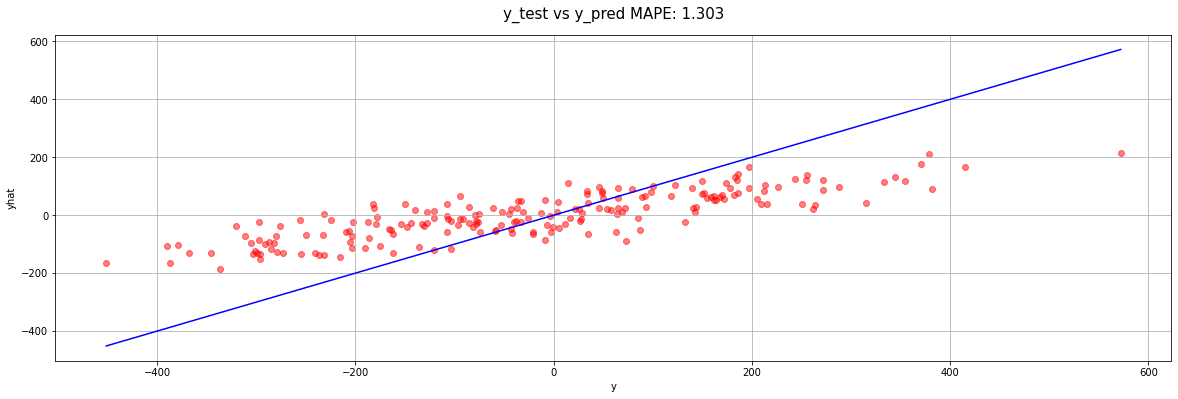

In [79]:
# make a elastic net regression function with gridsearchCV
def elastic_net_regression_gridsearchCV(X_train, y_train, X_test, y_test, alphas, l1_ratio, cv = 5, verbose = 1):
    '''
    This function makes a elastic net regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    alphas : numpy array
        alphas for the elastic net regression.
    l1_ratio : numpy array
        l1_ratio for the elastic net regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best elastic net regression fitted model   
    '''
    # create ElasticNet Modell with gridsearch cv
    elastic_net = ElasticNet()

    # create parameter grid
    param_grid = {"alpha": alphas, "l1_ratio": l1_ratio}

    # create gridsearchcv model
    elastic_net_grid = GridSearchCV(elastic_net, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    elastic_net_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", elastic_net_grid.best_params_)
    print("best estimator:", elastic_net_grid.best_estimator_)

    elastic_net.set_params(**elastic_net_grid.best_params_)

    elastic_net.fit(X_train, y_train)

    # predict the model
    y_pred = elastic_net.predict(X_test)

    # print the mean absolute percentage error
    mape_elastic_net = mean_absolute_percentage_error(y_test, elastic_net.predict(X_test))
    print("Mean absolute percentage error:", mape_elastic_net)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred, c="red", alpha=0.5)
    plot_lin = np.linspace(np.min(y_test), np.max(y_test), 2)
    plt.plot(plot_lin, plot_lin, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred MAPE: " + str(np.round(mape_elastic_net, 4)) , fontsize = 15, y = 1.03)
    plt.show()
    
# call the function
elastic_net_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.logspace(-1, 0, 10), np.logspace(-2, 0, 10))


---
# Modell 5 - KNN Regression

Modell 5 ist ein KNN Modell.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'n_neighbors': 11}
Mean absolute percentage error: 1.6804795098096599


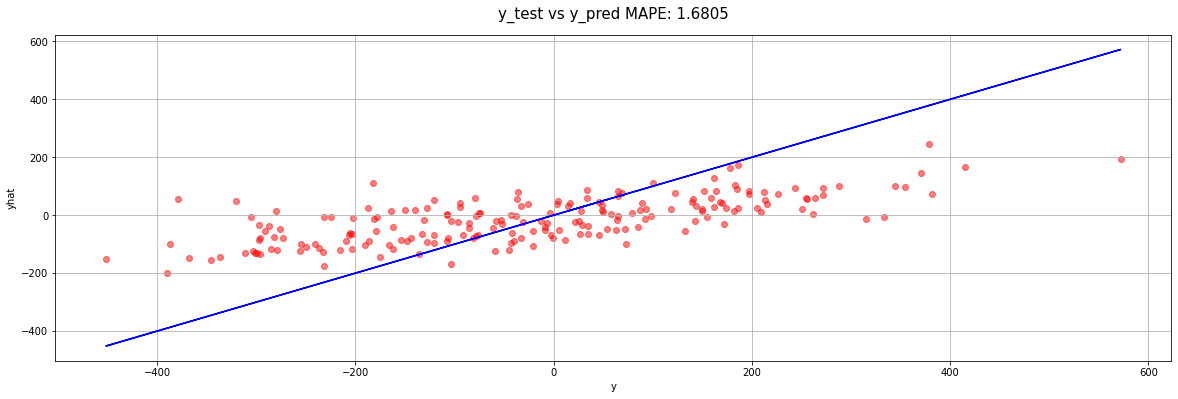

In [47]:
# make a KNN regression function with gridsearchCV
def knn_regression_gridsearchCV(X_train, y_train, X_test, y_test, n_neighbors, cv = 5, verbose = 1):
    '''
    This function makes a KNN regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    n_neighbors : numpy array
        n_neighbors for the KNN regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best KNN regression fitted model
    '''
    # create KNN Modell with gridsearch cv
    knn = KNeighborsRegressor()

    # create parameter grid
    param_grid = {"n_neighbors": n_neighbors}

    # create gridsearchcv model
    KNN_grid = GridSearchCV(knn, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    KNN_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", KNN_grid.best_params_)

    # overwrite the model with the best model
    KNN_grid = KNN_grid.best_estimator_

    # predict the model
    y_pred = KNN_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_knn = mean_absolute_percentage_error(y_test, KNN_grid.predict(X_test))
    print("Mean absolute percentage error:", mape_knn)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred, c="red", alpha=0.5)
    plt.plot(y_test, y_test, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred MAPE: " + str(np.round(mape_knn, 4)) , fontsize = 15, y = 1.03)
    plt.show()
    
# call the function
knn_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.arange(1, 25), cv = 5, verbose = 1)


---
# Modell 6 - Decision Tree Regression

Modell 6 ist ein Decision Tree Modell.

[Feedback] -> Variable importance

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best parameters: {'max_depth': 3}
Mean absolute percentage error: 1.9339943036742688


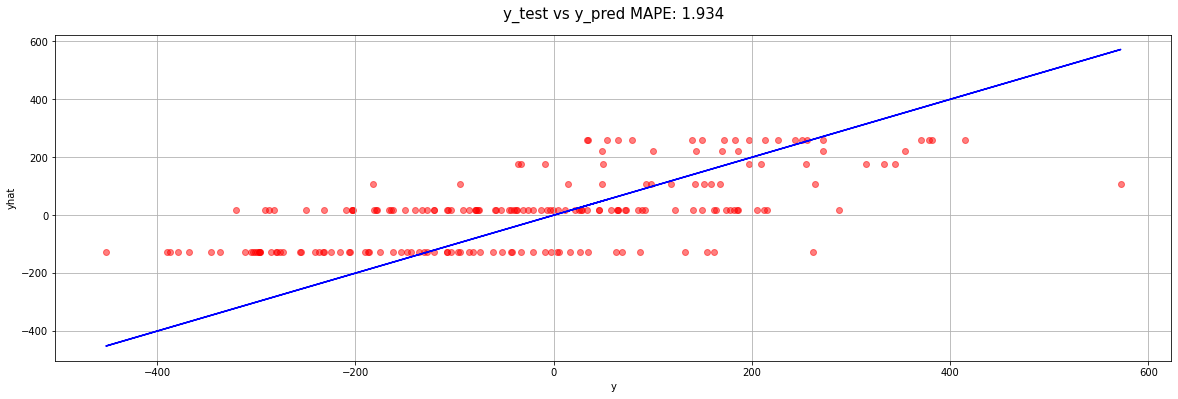

In [49]:
# make a Decision Tree regression function with gridsearchCV
def decision_tree_regression_gridsearchCV(X_train, y_train, X_test, y_test, max_depth, cv = 5, verbose = 1):
    '''
    This function makes a Decision Tree regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    max_depth : numpy array
        max_depth for the Decision Tree regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best Decision Tree regression fitted model 
    '''
    # create Decision Tree Modell with gridsearch cv
    decision_tree = DecisionTreeRegressor()

    # create parameter grid
    param_grid = {"max_depth": max_depth}

    # create gridsearchcv model
    dtr_grid = GridSearchCV(decision_tree, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    dtr_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", dtr_grid.best_params_)

    # overwrite the model with the best model
    dtr_grid = dtr_grid.best_estimator_

    # predict the model
    y_pred = dtr_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_dtr = mean_absolute_percentage_error(y_test, dtr_grid.predict(X_test))
    print("Mean absolute percentage error:", mape_dtr)


    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred, c="red", alpha=0.5)
    plt.plot(y_test, y_test, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred MAPE: " + str(np.round(mape_dtr, 4)) , fontsize = 15, y = 1.03)
    plt.show()
    
# call the function
decision_tree_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.arange(1, 20), cv = 5, verbose = 1)

---
# Modell 7 - Random Forest Regression

Modell 7 ist ein Random Forest Modell.

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'max_depth': 3, 'n_estimators': 8}
Mean absolute percentage error: 1.7205721002271497


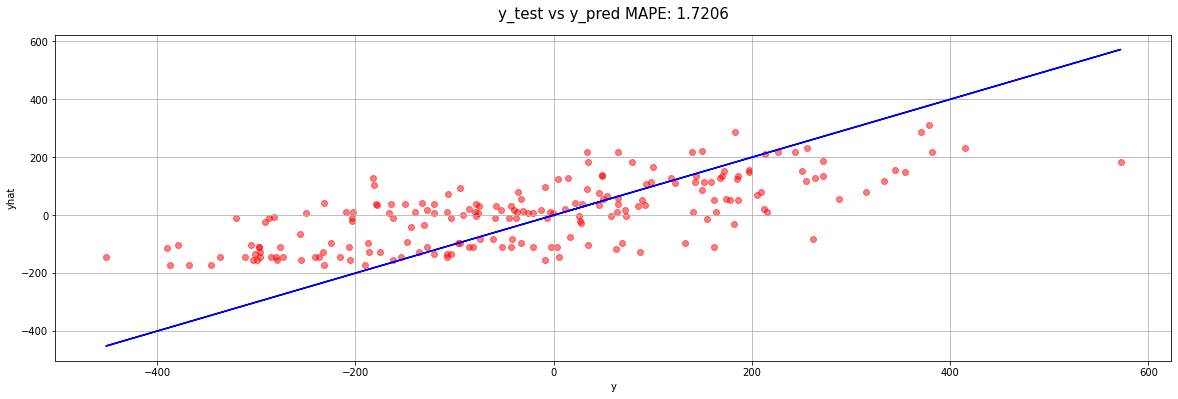

In [51]:
# make a Random Forest regression function with gridsearchCV
def random_forest_regression_gridsearchCV(X_train, y_train, X_test, y_test, max_depth, n_estimators, cv = 5, verbose = 1):
    '''
    This function makes a Random Forest regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    max_depth : numpy array
        max_depth for the Random Forest regression.
    n_estimators : numpy array
        n_estimators for the Random Forest regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best Random Forest regression fitted model 
    '''
    # create Random Forest Modell with gridsearch cv
    random_forest = RandomForestRegressor()

    # create parameter grid
    param_grid = {"max_depth": max_depth, "n_estimators": n_estimators}

    # create gridsearchcv model
    rf_grid = GridSearchCV(random_forest, param_grid, cv=cv, scoring="neg_mean_absolute_percentage_error", verbose=verbose)

    # fit the model
    rf_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", rf_grid.best_params_)

    # overwrite the model with the best model
    rf_grid = rf_grid.best_estimator_

    # predict the model
    y_pred = rf_grid.predict(X_test)

    # print the mean absolute percentage error
    mape_rf = mean_absolute_percentage_error(y_test, rf_grid.predict(X_test))
    print("Mean absolute percentage error:", mape_rf)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_test, y_pred, c="red", alpha=0.5)
    plt.plot(y_test, y_test, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title("y_test vs y_pred MAPE: " + str(np.round(mape_rf, 4)) , fontsize = 15, y = 1.03)
    plt.show()
    
# call the function
random_forest_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.arange(1, 10), np.arange(1, 10), cv = 5, verbose = 1)

---
# Modell 8 - Gradient Boosting Regression

Modell 8 ist ein Gradient Boosting Modell.

Best parameters: {'max_depth': 9, 'n_estimators': 5}
Best estimator: GradientBoostingRegressor(max_depth=9, n_estimators=5)
Mean absolute percentage error: 0.7369320686641078


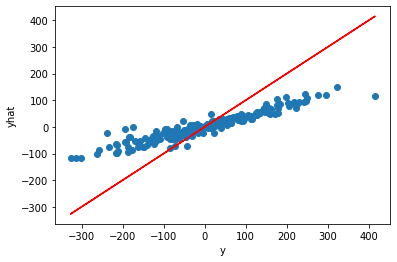

In [66]:
# make a Gradient Boosting regression function with gridsearchCV
def gradient_boosting_regression_gridsearchCV(X_train, y_train, X_test, y_test, max_depth, n_estimators):
    '''
    This function makes a Gradient Boosting regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_test : numpy array
        X_test data.
    y_test : numpy array
        y_test data.
    max_depth : numpy array
        max_depth for the Gradient Boosting regression.
    n_estimators : numpy array
        n_estimators for the Gradient Boosting regression.

    Returns
    -------
    None.   
    '''
    # create Gradient Boosting Modell with gridsearch cv
    gradient_boosting = GradientBoostingRegressor()

    # create parameter grid 
    # add more parameters to the parameter grid
    param_grid = {"max_depth": max_depth, "n_estimators": n_estimators}
    grid = GridSearchCV(gradient_boosting, param_grid, cv=5, scoring="neg_mean_absolute_percentage_error")

    # fit the model
    grid.fit(X_train, y_train)

    # print the best parameters
    # get best parameters in a dictionary
    best_params = grid.best_params_
    print("Best parameters:", grid.best_params_)
    print("Best estimator:", grid.best_estimator_)

    # predict the model
    y_pred = grid.predict(X_test)

    # print the mean absolute percentage error
    print("Mean absolute percentage error:", mean_absolute_percentage_error(y_test, y_pred))

    # create plot y vs yhat an draw model line
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.show()

# call the function
gradient_boosting_regression_gridsearchCV(X_train_dev, y_train_dev, X_test_dev, y_test_dev, np.arange(1, 10), np.arange(1, 10))


---
# Modell 9 - XGBoost Regression

Modell 9 ist ein XGBoost Modell.

---
# Vergleiche der Modelle

Hier werden die Modelle miteinander verglichen und tabellerisch sowie visualisiert dargestellt.
Dabei dient das Modell 1 - Multiple Linear Model, als Benchmark.

In [ ]:
# create a dataframe with the results
results = pd.DataFrame({"Model": ["Linear Regression", "Decision Tree", "Random Forest", "Gradient Boosting"],
                        "Mean absolute percentage error": [mean_absolute_percentage_error(y_test_dev, y_pred_linear_regression),
                                                            


---
# Untersuchung der "Variable Importance" für das beste Modell

Hier untersuchen wir die "Variable Importance" für das beste Modell.
Es hat sich herausgestellt, dass die .....

In [ ]:
# CODE

---
# Fazit

Hier schreiben wir unser Fazit.